In [ ]:
#Load/mount the file directory
from google.colab import drive
drive.flush_and_unmount()         # unmount if already mounted
!rm -rf /content/drive            # clear old directory handle
drive.mount('/content/drive', force_remount=True)


Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:

!pip -q install imbalanced-learn pillow imagehash scikit-fuzzy

import os, random, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import imagehash
import cv2 as cv

# Features
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# (Optional) texture features à la paper (ABCD-like/statistics)
from skimage.feature import graycomatrix, graycoprops

# Splits & metrics
from sklearn.model_selection import GroupShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score
)
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 22.2 MB/s eta 0:00:00


In [ ]:

melasma_dir = '/content/drive/MyDrive/original_melasma'
others_dir  = '/content/drive/MyDrive/og_nonmelasma'

def collect_images(root):
    exts = {'.jpg','.jpeg','.png','.bmp','.webp','.tif','.tiff','.gif','.jfif','.pjpeg','.pjp'}
    root = Path(root)
    if not root.exists():
        print(f"[!] Missing folder: {root}")
        return []
    return [str(p) for p in root.rglob('*') if p.suffix.lower() in exts]

melasma_paths = sorted(collect_images(melasma_dir))
others_paths  = sorted(collect_images(others_dir))

X_paths = melasma_paths + others_paths
y       = np.array([1]*len(melasma_paths) + [0]*len(others_paths))  # 1=Melasma, 0=Others

print(f"#Melasma={len(melasma_paths)}  #Others={len(others_paths)}  #Total={len(X_paths)}")


#Melasma=30  #Others=33  #Total=63


In [ ]:
# Step 3: Group near-duplicate images via perceptual hashing (pHash)
# phash_groups() assigns a group id to visually similar images using Hamming distance on pHash.
# Group IDs let us do group-exclusive splitting to avoid leakage of near-duplicates across splits.
# Tune distance_thresh to be stricter/looser (smaller = stricter).

def phash_groups(paths, hash_size=16, distance_thresh=4):
    N = len(paths)
    phashes = []
    for p in paths:
        try:
            with Image.open(p) as im:
                phashes.append(imagehash.phash(im.convert('RGB'), hash_size=hash_size))
        except Exception:
            phashes.append(None)

    groups = [-1]*N
    gid = 0
    for i in range(N):
        if groups[i] != -1: continue
        groups[i] = gid
        if phashes[i] is None:
            gid += 1; continue
        for j in range(i+1, N):
            if groups[j] != -1 or phashes[j] is None: continue
            if (phashes[i] - phashes[j]) <= distance_thresh:
                groups[j] = gid
        gid += 1
    return np.array(groups, dtype=int)

groups = phash_groups(X_paths, hash_size=16, distance_thresh=4)
print("Unique groups:", len(np.unique(groups)))


Unique groups: 63


In [ ]:
# Step 4: Build feature extractors (VGG16 and optional GLCM)
# vgg16_features(): loads images, preprocesses for VGG16, returns 512-D embeddings (ImageNet features).
# glcm_features(): (optional) computes texture descriptors (contrast, homogeneity, energy, correlation)
# across multiple distances/angles on a quantized grayscale. Useful if you want ABCD-like statistics.

vgg = VGG16(weights='imagenet', include_top=False, pooling='avg')

def vgg16_features(paths, batch=32):
    feats = []
    for i in range(0, len(paths), batch):
        batch_paths = paths[i:i+batch]
        imgs = []
        for p in batch_paths:
            img = cv.imread(p)
            if img is None:
                print(f"[warn] unreadable image skipped: {p}")
                continue
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, (224, 224))
            imgs.append(img)
        if not imgs: continue
        arr = np.array(imgs, dtype=np.float32)
        arr = preprocess_input(arr)
        f   = vgg.predict(arr, verbose=0)   # (B, 512)
        feats.append(f)
    if not feats: return np.empty((0, 512), dtype=np.float32)
    return np.vstack(feats).astype(np.float32)

def glcm_features(paths, resize_to=(256,256), levels=32, distances=(1,2,4), angles=(0, np.pi/4, np.pi/2, 3*np.pi/4)):
    feats = []
    for p in paths:
        try:
            img = Image.open(p).convert('L').resize(resize_to, Image.BILINEAR)
        except Exception:
            print(f"[warn] unreadable image skipped: {p}");
            continue
        arr = np.asarray(img, dtype=np.uint8)
        arr_q = (arr / (256/levels)).astype(np.uint8)
        glcm = graycomatrix(arr_q, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
        props = []
        for prop in ('contrast','homogeneity','energy','correlation'):
            props.append(graycoprops(glcm, prop).ravel())
        vec = np.concatenate(props, axis=0)
        feats.append(vec.astype(np.float32))
    if not feats:
        return np.empty((0, len(distances)*len(angles)*4), dtype=np.float32)
    return np.vstack(feats).astype(np.float32)

# Step 5: Choose which features to use (VGG only / GLCM only / concatenation)
# Three modes:
#   USE_GLCM_ONLY=True     -> use only GLCM texture features.
#   CONCAT_GLCM=True        -> concatenate standardized VGG16 + standardized GLCM features.
#   else                    -> default to VGG16 features only.
# Produces X_all (features), while y_all and groups_all mirror labels and pHash groups.

USE_GLCM_ONLY = False
CONCAT_GLCM   = False

if USE_GLCM_ONLY:
    X_all = glcm_features(X_paths)
elif CONCAT_GLCM:
    X_vgg  = vgg16_features(X_paths)
    X_glcm = glcm_features(X_paths)

    vgg_s  = StandardScaler().fit_transform(X_vgg)
    glcm_s = StandardScaler(with_mean=True, with_std=True).fit_transform(X_glcm)
    X_all  = np.hstack([vgg_s, glcm_s]).astype(np.float32)
else:
    X_all = vgg16_features(X_paths)

y_all      = y.copy()
groups_all = groups.copy()
print("Features:", X_all.shape, "  labels:", y_all.shape, "  groups:", groups_all.shape)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Features: (63, 512)   labels: (63,)   groups: (63,)


In [ ]:
# Step 6: Group-exclusive train/test split
# Use GroupShuffleSplit to create a held-out TEST set that is group-exclusive
# (no near-duplicate images across splits). Prints split shapes and class counts.

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tr_idx, te_idx = next(gss.split(X_all, y_all, groups=groups_all))

X_tr, X_te = X_all[tr_idx], X_all[te_idx]
y_tr, y_te = y_all[tr_idx], y_all[te_idx]
print("Train:", X_tr.shape, " Test:", X_te.shape)
print("Train counts:", np.bincount(y_tr), "  Test counts:", np.bincount(y_te))


Train: (50, 512)  Test: (13, 512)
Train counts: [26 24]   Test counts: [7 6]


In [ ]:
# Step 7: Define an FCM (Fuzzy C-Means) classifier as a scikit-learn estimator
#FCMClassifier:
#Splits training data by class and runs FCM per class to learn multiple prototypes per class.
#m is the fuzzifier (>1). k0/k1 are number of prototypes for class 0/1.
#Features are optionally z-scored (scale=True).
#predict_proba(): computes class supports from inverse distance to learned prototypes and normalizes.
#predict(): threshold probability of class 1 at 0.5 to yield binary labels.

class FCMClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, m=2.0, k0=2, k1=2, max_iter=150, tol=1e-4, scale=True, random_state=42):
        self.m = float(m); self.k0=int(k0); self.k1=int(k1)
        self.max_iter=int(max_iter); self.tol=float(tol)
        self.scale=bool(scale); self.random_state=int(random_state)

    def _init_scaler(self, X):
        if self.scale:
            self._scaler = StandardScaler().fit(X)
            return self._scaler.transform(X)
        else:
            self._scaler = None
            return X

    def _transform(self, X):
        if getattr(self, "_scaler", None) is not None:
            return self._scaler.transform(X)
        return X

    @staticmethod
    def _fcm(X, C, m, max_iter, tol, rnd):
        """
        Basic FCM on data X into C clusters.
        Returns centers (C,D). Based on standard objective.
        """
        rng = np.random.RandomState(rnd)
        N, D = X.shape
        # initialize memberships randomly, rows sum to 1
        U = rng.rand(N, C); U = U / (U.sum(axis=1, keepdims=True) + 1e-12)

        for _ in range(max_iter):
            # cluster centers
            Um = U ** m
            centers = (Um.T @ X) / (Um.sum(axis=0, keepdims=True).T + 1e-12)

            # distances to centers (N,C)
            d2 = np.maximum(
                np.sum((X[:,None,:] - centers[None,:,:])**2, axis=2),
                1e-12
            )
            # update membership
            inv = (d2 ** (-1.0/(m-1)))
            U_new = inv / (np.sum(inv, axis=1, keepdims=True) + 1e-12)

            # check change
            if np.linalg.norm(U_new - U) < tol:
                U = U_new; break
            U = U_new

        return centers, U

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=int)
        self.classes_ = np.array([0,1], dtype=int)  # assumed binary
        Xs = self._init_scaler(X)

        # split by class
        X0, X1 = Xs[y==0], Xs[y==1]
        if len(X0)==0 or len(X1)==0:
            raise ValueError("Both classes must be present in training data.")

        # run FCM separately per class → get prototypes & exponents
        self.C0_, self.U0_ = self._fcm(X0, self.k0, self.m, self.max_iter, self.tol, self.random_state)
        self.C1_, self.U1_ = self._fcm(X1, self.k1, self.m, self.max_iter, self.tol, self.random_state+1)
        return self

    def predict_proba(self, X):
        X = np.asarray(X, dtype=np.float32)
        Z = self._transform(X)
        # memberships to class-0 prototypes
        d0 = np.maximum(np.sum((Z[:,None,:]-self.C0_[None,:,:])**2, axis=2), 1e-12)
        w0 = (d0 ** (-1.0/(self.m-1)))  # (N,k0)
        s0 = w0.sum(axis=1)             # per-sample class-0 support

        # memberships to class-1 prototypes
        d1 = np.maximum(np.sum((Z[:,None,:]-self.C1_[None,:,:])**2, axis=2), 1e-12)
        w1 = (d1 ** (-1.0/(self.m-1)))  # (N,k1)
        s1 = w1.sum(axis=1)             # per-sample class-1 support

        S = np.vstack([s0, s1]).T + 1e-12
        probs = S / S.sum(axis=1, keepdims=True)
        # order: [class0, class1]
        return probs

    def predict(self, X):
        probs = self.predict_proba(X)
        return (probs[:,1] >= 0.5).astype(int)


In [ ]:
fcm = FCMClassifier()

param_grid = {
    "m":  [1.5, 2.0, 2.5],
    "k0": [1, 2, 3],     # #prototypes for Others
    "k1": [1, 2, 3],     # #prototypes for Melasma
}
# Step 8: Hyperparameter search over FCM (inner CV on TRAIN)
# GridSearchCV tunes (m, k0, k1) with StratifiedKFold(n_splits=5), using F1 as the score to be robust
# to imbalance. Fits only on X_tr/y_tr to avoid test leakage. best_fcm is the tuned classifier.

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(
    fcm, param_grid,
    scoring='f1', cv=inner_cv, n_jobs=-1, verbose=1, error_score=np.nan
)
gs.fit(X_tr, y_tr)
best_fcm = gs.best_estimator_
print("Best params:", gs.best_params_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params: {'k0': 1, 'k1': 1, 'm': 1.5}


              precision    recall  f1-score   support

      Others       1.00      0.86      0.92         7
     Melasma       0.86      1.00      0.92         6

    accuracy                           0.92        13
   macro avg       0.93      0.93      0.92        13
weighted avg       0.93      0.92      0.92        13



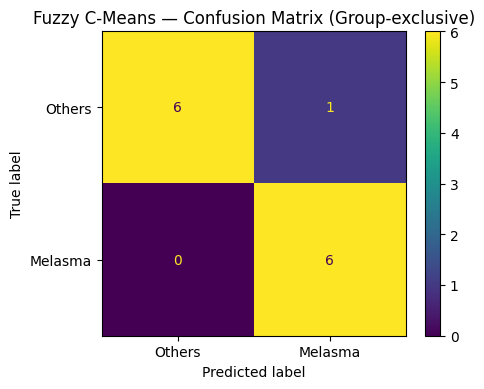

ROC-AUC: 0.9761904761904763


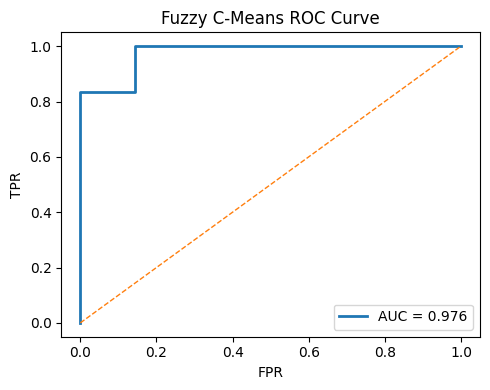

In [ ]:
# Step 9: Final evaluation on held-out TEST split

y_pred = best_fcm.predict(X_te)
y_prob = best_fcm.predict_proba(X_te)[:, 1]  # prob of Melasma

print(classification_report(y_te, y_pred, target_names=["Others","Melasma"]))

cm = confusion_matrix(y_te, y_pred, labels=[0,1])
fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay(cm, display_labels=["Others","Melasma"]).plot(ax=ax)
plt.title("Fuzzy C-Means — Confusion Matrix (Group-exclusive)")
plt.tight_layout(); plt.show()

fpr, tpr, _ = roc_curve(y_te, y_prob)
print("ROC-AUC:", auc(fpr, tpr))
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr):.3f}")
plt.plot([0,1],[0,1],'--', lw=1)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Fuzzy C-Means ROC Curve"); plt.legend(); plt.tight_layout(); plt.show()


 Correctly Classified Melasma Samples 


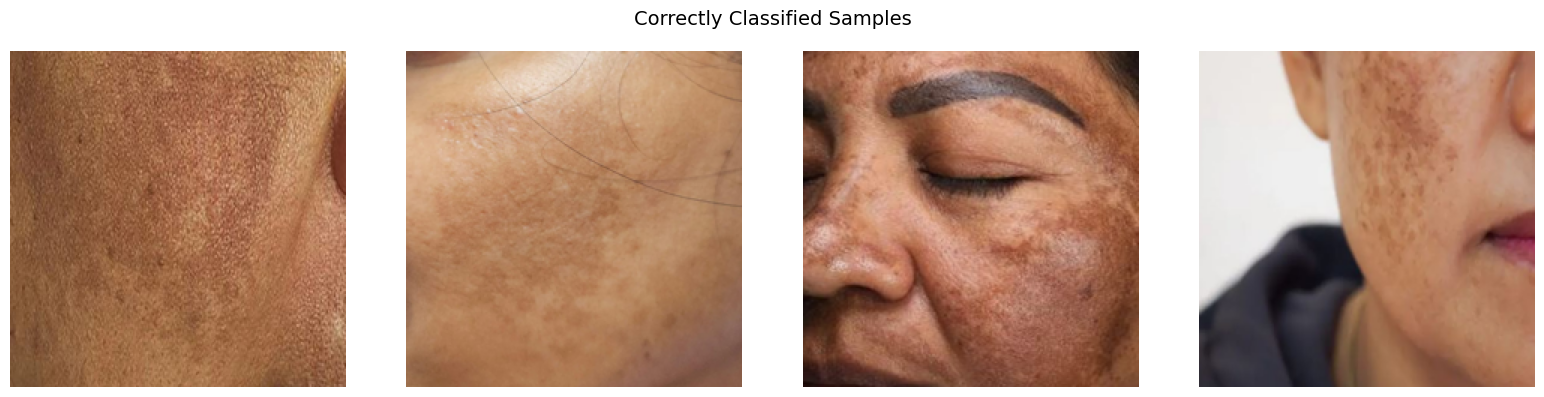

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from PIL import Image

# --- Predict a single image ---
def predict_one_img_path(path, clf, feature_extractor, preprocess_fn):
    """Predicts the class and confidence score for a single image path."""
    img = Image.open(path).convert('RGB').resize((224, 224))
    arr = np.array(img, dtype=np.float32)[None, ...]
    arr = preprocess_fn(arr)
    feat = feature_extractor.predict(arr, verbose=0)
    prob1 = clf.predict_proba(feat)[0, 1]
    pred = int(prob1 >= 0.5)
    return pred, prob1, img


# --- Helper to display images in a single horizontal row ---
def display_images_in_row(paths, title, color, clf, feature_extractor, preprocess_fn):
    """Displays given image paths in a single horizontal row."""
    plt.figure(figsize=(4 * len(paths), 4))
    for i, p in enumerate(paths):
        pred, prob1, img = predict_one_img_path(p, clf, feature_extractor, preprocess_fn)
        conf = prob1 if pred == 1 else (1 - prob1)
        plt.subplot(1, len(paths), i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


# --- Show correctly classified samples ---
def show_classified_samples(paths, true_label, clf, feature_extractor, preprocess_fn, k=4):
    """Selects correctly classified examples and displays them horizontally."""
    correct = []
    for p in paths:
        pred, _, _ = predict_one_img_path(p, clf, feature_extractor, preprocess_fn)
        if pred == true_label:
            correct.append(p)
    selected = random.sample(correct, min(k, len(correct)))
    display_images_in_row(selected, "Correctly Classified Samples", "green",
                          clf, feature_extractor, preprocess_fn)


# --- Show misclassified samples ---
def show_misclassified_samples(paths, true_label, clf, feature_extractor, preprocess_fn, k=4):
    """Selects misclassified examples and displays them horizontally."""
    wrong = []
    for p in paths:
        pred, _, _ = predict_one_img_path(p, clf, feature_extractor, preprocess_fn)
        if pred != true_label:
            wrong.append(p)
    selected = random.sample(wrong, min(k, len(wrong)))
    display_images_in_row(selected, "Misclassified Samples", "red",
                          clf, feature_extractor, preprocess_fn)



print(" Correctly Classified Melasma Samples ")
show_classified_samples(melasma_paths, true_label=1, clf=best_fcm,
                        feature_extractor=vgg, preprocess_fn=preprocess_input, k=4)



=== Classified Non-Melasma Samples ===


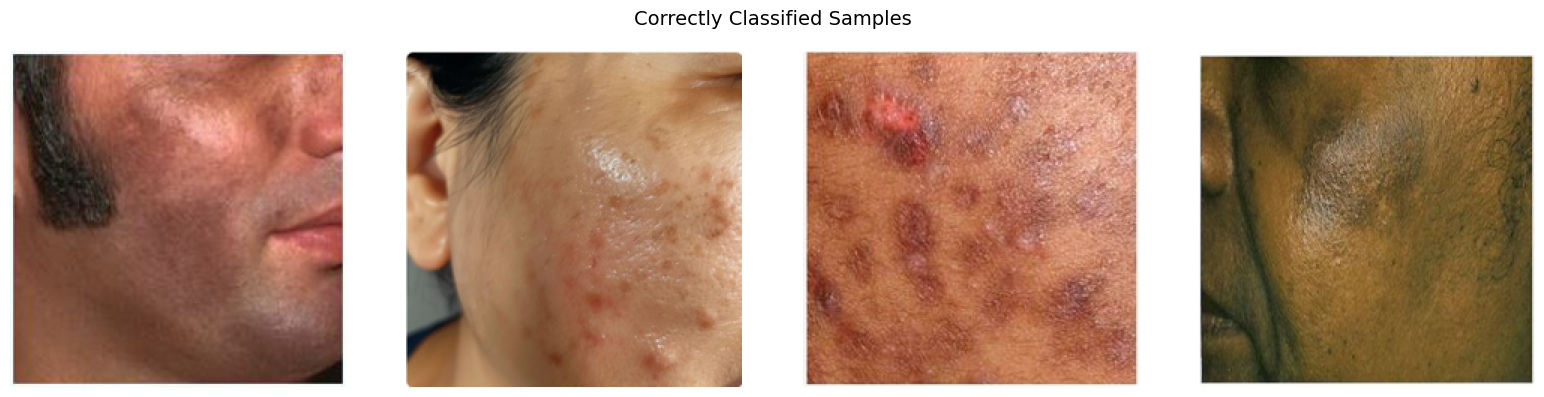

In [ ]:
print("=== Classified Non-Melasma Samples ===")
show_classified_samples(others_paths, true_label=1, clf=best_fcm,
                        feature_extractor=vgg, preprocess_fn=preprocess_input, k=4)

In [ ]:
print("=== Misclassified Melasma Samples ===")
show_misclassified_samples(melasma_paths, true_label=1, clf=best_fcm,
                           feature_extractor=vgg, preprocess_fn=preprocess_input, k=4)


=== Misclassified Melasma Samples ===


<Figure size 0x400 with 0 Axes>

=== Misclassified Non-Melasma Samples ===


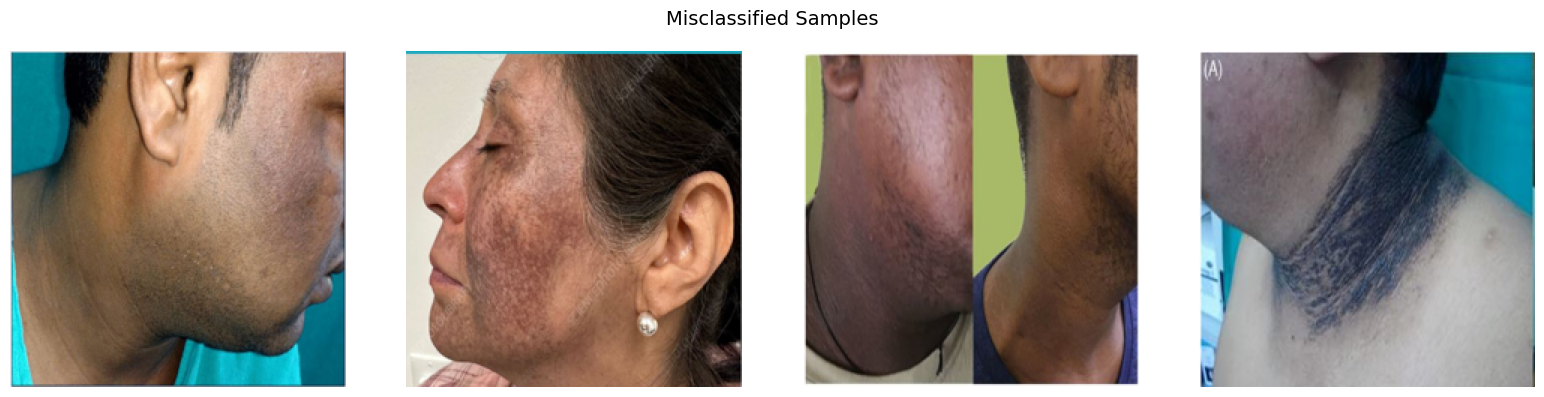

In [ ]:
print("=== Misclassified Non-Melasma Samples ===")
show_misclassified_samples(others_paths, true_label=1, clf=best_fcm,
                           feature_extractor=vgg, preprocess_fn=preprocess_input, k=4)